# LSTM Text classification using Tensorflow 2.0 Alpha

# Tensorflow 2.0 Alpha important information:
- [Official TF2 Alpha](https://www.tensorflow.org/alpha)
- [New Features in TF 2](https://medium.com/tensorflow/whats-coming-in-tensorflow-2-0-d3663832e9b8)
- [Standardizing on Keras for TF2](https://medium.com/tensorflow/standardizing-on-keras-guidance-on-high-level-apis-in-tensorflow-2-0-bad2b04c819a)
- [TF2 GPU installation guide](https://www.tensorflow.org/install/gpu)

# Importing Libraries

### Installing TF-gpu 2.0 Alpha

In [1]:
!pip install tensorflow-gpu==2.0.0-alpha0

    100% |████████████████████████████████| 332.1MB 119kB/s eta 0:00:01                    | 83.6MB 32.5MB/s eta 0:00:08    28% |█████████                       | 93.8MB 38.2MB/s eta 0:00:07    63% |████████████████████▌           | 212.4MB 36.0MB/s eta 0:00:04    72% |███████████████████████         | 239.5MB 34.2MB/s eta 0:00:03    74% |███████████████████████▉        | 247.3MB 36.6MB/s eta 0:00:03    76% |████████████████████████▍       | 252.7MB 6.8MB/s eta 0:00:12    89% |████████████████████████████▋   | 297.2MB 33.6MB/s eta 0:00:02
    100% |████████████████████████████████| 61kB 17.9MB/s ta 0:00:01
    100% |████████████████████████████████| 3.0MB 8.9MB/s eta 0:00:01
    100% |████████████████████████████████| 419kB 25.5MB/s ta 0:00:01


In [2]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import operator
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

from tqdm import tqdm
tqdm.pandas()

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras import layers

%matplotlib inline
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 1000)

# Environment checks

#### Check Tensorflow Version

In [3]:
print(tf.__version__)

2.0.0-alpha0


#### Check GPU detection for tensorflow

In [4]:
x = tf.random.uniform([3, 3])

print("Is there a GPU available: "),
print(tf.test.is_gpu_available())

print("Is the Tensor on GPU #0:  "),
print(x.device.endswith('GPU:0'))

print("Device name: {}".format((x.device)))

Is there a GPU available: 
True
Is the Tensor on GPU #0:  
True
Device name: /job:localhost/replica:0/task:0/device:GPU:0


#### Check if Eager execution is running
- Eager execution enables a more interactive frontend to TensorFlow, the details of which we will discuss much later.
- [Eager basics official guide](https://www.tensorflow.org/tutorials/eager/eager_basics)

In [5]:
print(tf.executing_eagerly())

True


In [6]:
print(tf.keras.__version__)

2.2.4-tf


# Importing data

In [7]:
df  = pd.read_csv("../input/train.csv")
df_test = pd.read_csv('../input/test.csv')


In [8]:
df[df.target==1].head(10)

,qid,question_text,target
22,0000e91571b60c2fb487,Has the United States become the largest dictatorship in the world?,1
30,00013ceca3f624b09f42,Which babies are more sweeter to their parents? Dark skin babies or light skin babies?,1
110,0004a7fcb2bf73076489,If blacks support school choice and mandatory sentencing for criminals why don't they vote Republican?,1
114,00052793eaa287aff1e1,"I am gay boy and I love my cousin (boy). He is sexy, but I dont know what to do. He is hot, and I want to see his di**. What should I do?",1
115,000537213b01fd77b58a,Which races have the smallest penis?,1
119,00056d45a1ce63856fc6,Why do females find penises ugly?,1
127,0005de07b07a17046e27,How do I marry an American woman for a Green Card? How much do they charge?,1
144,00068875d7c82a5bcf88,"Why do Europeans say they're the superior race, when in fact it took them over 2,000 years until mid 19th century to surpass China's largest economy?",1
156,0006ffd99a6599ff35b3,Did Julius Caesar bring a tyrannosaurus rex on his campaigns to frighten the Celts into submission?,1
167,00075f7061837807c69f,In what manner has Republican backing of 'states rights' been hypocritical and what ways have they actually restricted the ability of states to make their own laws?,1


In [9]:
print("Number of questions: ", df.shape[0])

Number of questions:  1306122


# EDA on the Question Text corpus

## Target variable response rate
- __6.18 %__ questions are insincere in the provided dataset

In [10]:
df.target.value_counts()

0    1225312
1      80810
Name: target, dtype: int64

In [11]:
print("Percentage of insincere questions: {}".format(sum(df.target == 1)*100/len(df.target)))

Percentage of insincere questions: 6.187017751787352


## Wordclouds for the question text corpus
- This will show us the most frequently used words for sincere and insincere labeled questions

### Defining function for generating wordcloud

In [12]:
# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  


### Wordcloud for sincere questions

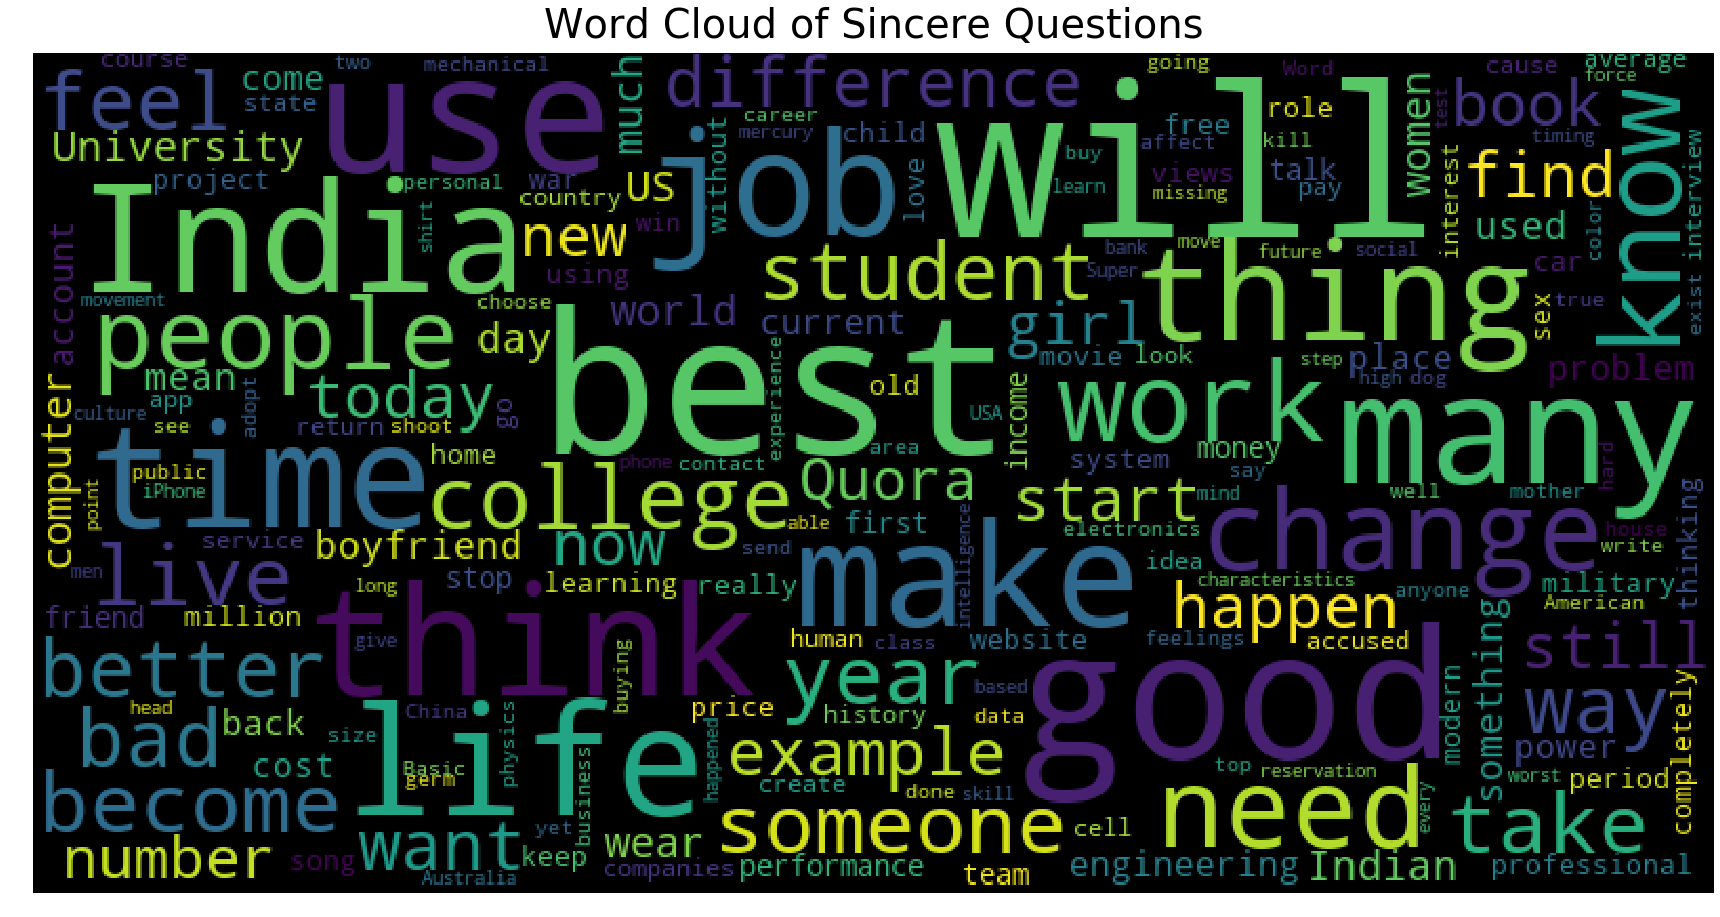

In [13]:
plot_wordcloud(df[df.target == 0]["question_text"], title="Word Cloud of Sincere Questions")

### Wordcloud for insincere questions
- We observe that insincere questions contain highly debated and emotion based topics of Trump, Muslims, America, Russia, Obama, Liberal etc.

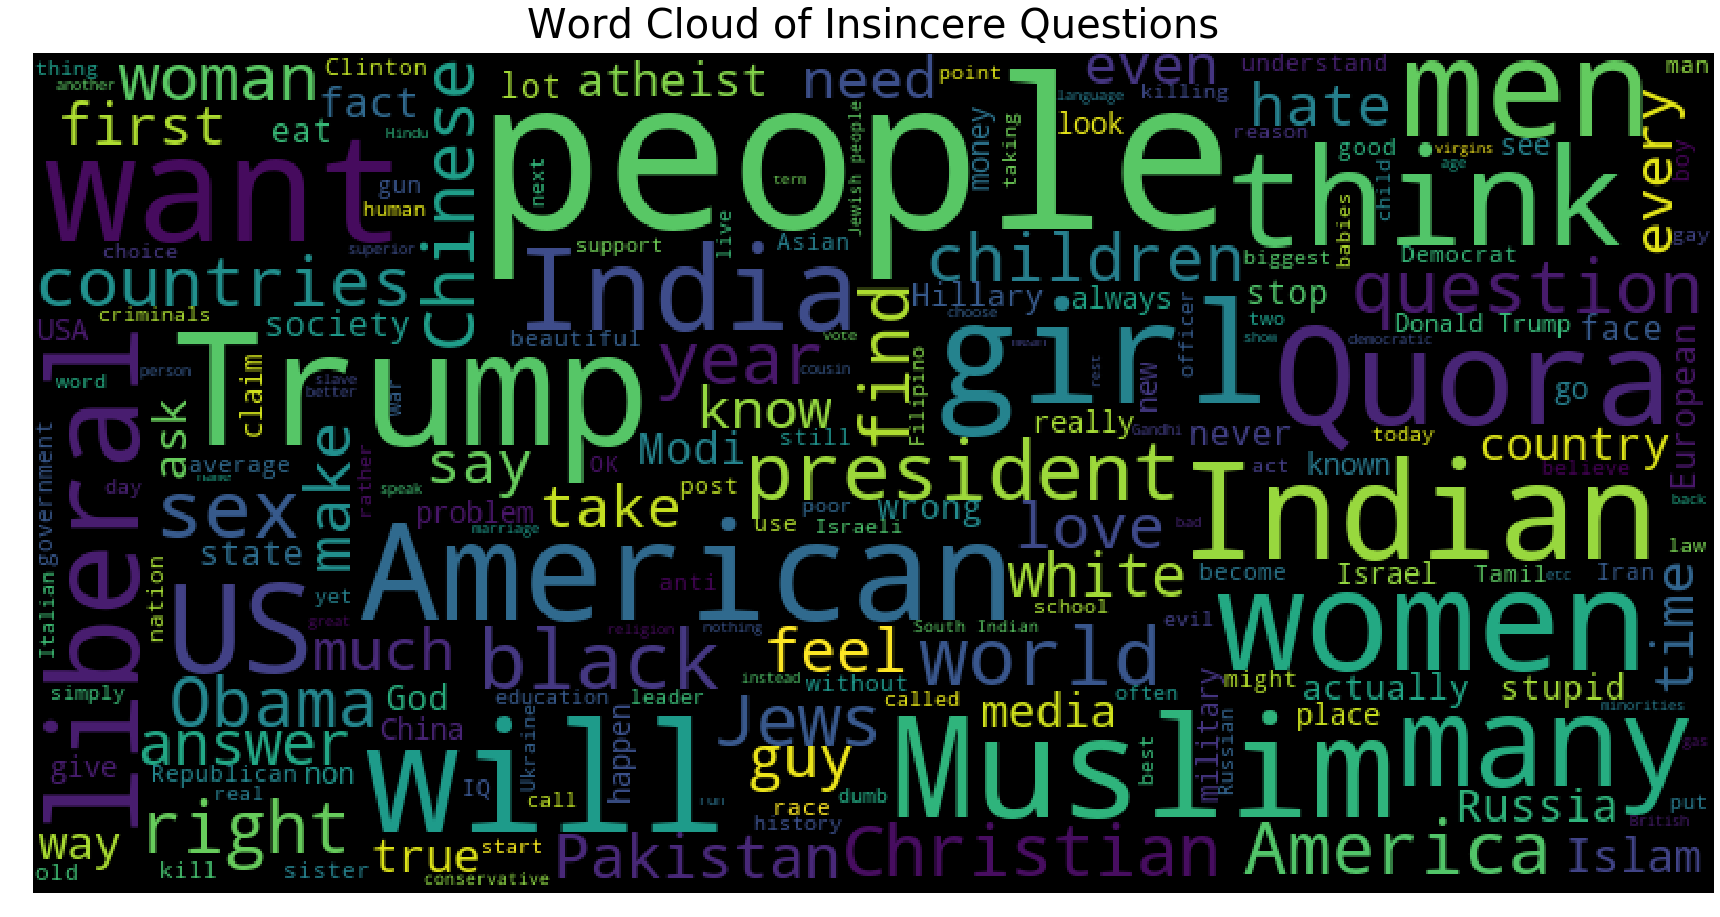

In [14]:
plot_wordcloud(df[df.target == 1]["question_text"], title="Word Cloud of Insincere Questions")

## Word frequency and n-gram frequency
- Frequency of words can show the most used words for sincere and insincere questions
- N-grams can be useful in distinguishing sincere and insincere questions by identifying patterns in topics

In [15]:
stopwords = set(STOPWORDS)

In [16]:
sincere_words = df[df.target==0].question_text.apply(lambda x: x.lower().split()).tolist()
insincere_words = df[df.target==1].question_text.apply(lambda x: x.lower().split()).tolist()

sincere_words = [item for sublist in sincere_words for item in sublist if item not in stopwords]
insincere_words = [item for sublist in insincere_words  for item in sublist if item not in stopwords ]

In [17]:
print('Number of sincere words',len(sincere_words))
print('Number of insincere words',len(insincere_words))

Number of sincere words 7743544
Number of insincere words 734398


In [18]:
sincere_words_counter = Counter(sincere_words)
insincere_words_counter = Counter(insincere_words)

### Most common sincere words

In [19]:
most_common_sincere_words = sincere_words_counter.most_common()[:10]
most_common_sincere_words = pd.DataFrame(most_common_sincere_words)
most_common_sincere_words.columns = ['word', 'freq']
most_common_sincere_words['percentage'] = most_common_sincere_words.freq *100 / sum(most_common_sincere_words.freq)
most_common_sincere_words

,word,freq,percentage
0,best,60816,19.240759
1,will,45675,14.450501
2,people,37960,12.009656
3,good,34827,11.018448
4,one,28840,9.124301
5,make,25696,8.129613
6,think,21641,6.846706
7,many,20788,6.576837
8,much,20108,6.361701
9,someone,19728,6.241478


### Most common insincere words

In [20]:
most_common_insincere_words = insincere_words_counter.most_common()[:10]
most_common_insincere_words = pd.DataFrame(most_common_insincere_words)
most_common_insincere_words.columns = ['word', 'freq']
most_common_insincere_words['percentage'] = most_common_insincere_words.freq *100 / sum(most_common_insincere_words.freq)
most_common_insincere_words

,word,freq,percentage
0,people,11041,24.570500
1,trump,4893,10.888820
2,women,4760,10.592843
3,will,4592,10.218978
4,think,3774,8.398611
5,many,3552,7.904575
6,white,3354,7.463949
7,men,3152,7.014421
8,indian,2986,6.645006
9,muslims,2832,6.302297


### Function for generating n-grams

In [21]:
def generate_ngrams(words, n):
    
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    ngrams = zip(*[words[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

In [22]:
n = 3

In [23]:
sincere_ngram_counter = Counter(generate_ngrams(sincere_words, n))
insincere_ngram_counter = Counter(generate_ngrams(insincere_words, n))

### Most common sincere n-grams

In [24]:
most_common_sincere_ngram = sincere_ngram_counter.most_common()[:10]
most_common_sincere_ngram = pd.DataFrame(most_common_sincere_ngram)
most_common_sincere_ngram.columns = ['word', 'freq']
most_common_sincere_ngram['percentage'] = most_common_sincere_ngram.freq *100 / sum(most_common_sincere_ngram.freq)
most_common_sincere_ngram

,word,freq,percentage
0,tips someone starting,716,12.402564
1,useful tips someone,713,12.350598
2,someone starting work,713,12.350598
3,advice give someone,640,11.086090
4,give someone moving,519,8.990126
5,good hotels short-term,519,8.990126
6,hotels short-term business,519,8.990126
7,short-term business travelers,519,8.990126
8,good bad neighborhoods,515,8.920838
9,best known for?,400,6.928807


### Most common insincere n-grams
- We observe a pattern of suggestive/controversial n-grams amongst the insincere questions

In [25]:
most_common_insincere_ngram = insincere_ngram_counter.most_common()[:10]
most_common_insincere_ngram = pd.DataFrame(most_common_insincere_ngram)
most_common_insincere_ngram.columns = ['word', 'freq']
most_common_insincere_ngram['percentage'] = most_common_insincere_ngram.freq *100 / sum(most_common_insincere_ngram.freq)
most_common_insincere_ngram

,word,freq,percentage
0,will donald trump,43,12.250712
1,black lives matter,42,11.965812
2,long will take,38,10.826211
3,kim jong un,36,10.256410
4,12 year old,35,9.971510
5,14 year old,33,9.401709
6,people still believe,33,9.401709
7,united states america,31,8.831909
8,think donald trump,30,8.547009
9,ask stupid questions,30,8.547009


# Parameters for preprocessing and algorithms

In [26]:
# config values
embed_size = 300 # how big is each word vector
max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a question to use

# Data Preparation

## Training and Test data split

In [27]:
X_train, X_test  = train_test_split(df, test_size=0.1, random_state=2019)
y_train, y_test = X_train['target'].values, X_test['target'].values

## Missing value treatment
- Fill missing questions with a string placeholder "\_NA\_"

In [28]:
X_train = X_train['question_text'].fillna('_NA_').values
X_test = X_test['question_text'].fillna('_NA_').values
X_submission = df_test['question_text'].fillna('_NA_').values

In [29]:
X_train.shape

(1175509,)

## Tokenizing the sentences to words

In [30]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_submission = tokenizer.texts_to_sequences(X_submission)

## Padding sequences for uniform dimensions

In [31]:
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)
X_submission = pad_sequences(X_submission, maxlen=maxlen)

## Data prep function for future use
- Creating a function including all of the above data prep steps, to use for quick future data processing

In [32]:
def data_prep(df):
    print("Splitting dataframe with shape {} into training and test datasets".format(df.shape))
    X_train, X_test  = train_test_split(df, test_size=0.1, random_state=2019)
    y_train, y_test = X_train['target'].values, X_test['target'].values
    
    print("Filling missing values")
    X_train = X_train['question_text'].fillna('_NA_').values
    X_test = X_test['question_text'].fillna('_NA_').values
    X_submission = df_test['question_text'].fillna('_NA_').values
    
    print("Tokenizing {} questions into words".format(df.shape[0]))
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(list(X_train))
    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)
    X_submission = tokenizer.texts_to_sequences(X_submission)
    
    print("Padding sequences for uniform dimensions")
    X_train = pad_sequences(X_train, maxlen=maxlen)
    X_test = pad_sequences(X_test, maxlen=maxlen)
    X_submission = pad_sequences(X_submission, maxlen=maxlen)
    
    print("Completed data preparation, returning training, test and submission datasets, split as dependent(X) and independent(Y) variables")
    
    return X_train, X_test, y_train, y_test, X_submission

# Define LSTM layers and parameters
- Bidirectional LSTM using CUDA GPU processing
- No embeddings used currently
- Two fully connected layers with dropout layers for reducing chances of overfit

In [33]:
model1 = Sequential()
model1.add(Embedding(max_features, embed_size, input_length=maxlen))
model1.add(Bidirectional(CuDNNLSTM(128, return_sequences=True)))
model1.add(GlobalMaxPool1D())
model1.add(Dropout(0.2))
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(32, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 256)          440320    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2

# Fit LSTM model 

In [34]:
%time model1.fit(X_train, y_train, batch_size=512, epochs=2, validation_data=(X_test, y_test), verbose = 1)

Train on 1175509 samples, validate on 130613 samples
Epoch 1/2
1175509/1175509 [==============================] - 131s 112us/sample - loss: 0.1245 - accuracy: 0.9527 - val_loss: 0.1108 - val_accuracy: 0.9556
Epoch 2/2
1175509/1175509 [==============================] - 129s 110us/sample - loss: 0.1005 - accuracy: 0.9599 - val_loss: 0.1098 - val_accuracy: 0.9569
CPU times: user 2min 20s, sys: 12.2 s, total: 2min 32s
Wall time: 4min 23s


# Predict using trained model

In [35]:
pred_test_y = model1.predict([X_test], batch_size=1024, verbose=1)


130613/130613 [==============================] - 4s 31us/sample


# Calculate optimal probability threshold for classification
- Calculating best probability cut-off giving the highest F1 - Score

In [36]:
opt_prob = None
f1_max = 0

for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    f1 = metrics.f1_score(y_test, (pred_test_y > thresh).astype(int))
    print('F1 score at threshold {} is {}'.format(thresh, f1))
    
    if f1 > f1_max:
        f1_max = f1
        opt_prob = thresh
        
print('Optimal probabilty threshold is {} for maximum F1 score {}'.format(opt_prob, f1_max))

F1 score at threshold 0.1 is 0.5899185378158209
F1 score at threshold 0.11 is 0.598753656365255
F1 score at threshold 0.12 is 0.606086881123732
F1 score at threshold 0.13 is 0.6122232533474745
F1 score at threshold 0.14 is 0.6191376361508687
F1 score at threshold 0.15 is 0.6250974279033515
F1 score at threshold 0.16 is 0.6310240261254956
F1 score at threshold 0.17 is 0.63577668059248
F1 score at threshold 0.18 is 0.6398456343463579
F1 score at threshold 0.19 is 0.6420985660451232
F1 score at threshold 0.2 is 0.6452734588445681
F1 score at threshold 0.21 is 0.6473965152583342
F1 score at threshold 0.22 is 0.6499234303215927
F1 score at threshold 0.23 is 0.6521312322397314
F1 score at threshold 0.24 is 0.6543229248391653
F1 score at threshold 0.25 is 0.6550500503151315
F1 score at threshold 0.26 is 0.6555388578789179
F1 score at threshold 0.27 is 0.655538034908379
F1 score at threshold 0.28 is 0.6569664902998237
F1 score at threshold 0.29 is 0.6582844369935736
F1 score at threshold 0.3 i

# Submission

In [37]:
pred_submission_y = model1.predict([X_submission], batch_size=1024, verbose=1)
pred_submission_y = (pred_submission_y > opt_prob).astype(int)

df_submission = pd.DataFrame({'qid': df_test['qid'].values})
df_submission['prediction'] = pred_submission_y
#df_submission.to_csv("submission.csv", index=False)

375806/375806 [==============================] - 11s 30us/sample


# Loading embeddings

## Function to load embeddings from file

In [38]:
def load_embed(file):
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    if file == '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec':
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding="utf8") if len(o)>100)
    else:
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
        
    return embeddings_index

In [39]:
glove = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
paragram =  '../input/embeddings/paragram_300_sl999/paragram_300_sl999.txt'
wiki_news = '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec'

In [40]:
print("Extracting GloVe embedding")
embed_glove = load_embed(glove)
#print("Extracting Paragram embedding")
#embed_paragram = load_embed(paragram)
#print("Extracting FastText embedding")
#embed_fasttext = load_embed(wiki_news)

Extracting GloVe embedding


# Building Vocabulary and calculating coverage

In [41]:
def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [42]:
def check_coverage(vocab, embeddings_index):
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(known_words) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

## Bulding dataset vocabulary

In [43]:
vocab = build_vocab(df['question_text'])

## Calculating coverage for each embedding

In [44]:
print("Glove : ")
oov_glove = check_coverage(vocab, embed_glove)
#print("Paragram : ")
#oov_paragram = check_coverage(vocab, embed_paragram)
#print("FastText : ")
#oov_fasttext = check_coverage(vocab, embed_fasttext)

Glove : 
Found embeddings for 33.02% of vocab
Found embeddings for  88.15% of all text


In [45]:
type(embed_glove)

dict

In [46]:
dict(list(embed_glove.items())[20:22])

{"'s": array([-6.8580e-02,  4.6470e-01,  1.3214e-01,  1.8599e-01, -3.7015e-02,
         3.2988e-01,  1.7865e-01, -2.5977e-01, -2.6022e-01,  2.5728e+00,
        -2.5867e-01, -6.6095e-01,  8.1984e-02,  1.0321e-02, -1.2223e-01,
         9.4609e-03, -8.8657e-02,  5.8367e-01, -1.7465e-02, -3.5569e-01,
        -1.0182e-01,  6.1941e-02, -1.4267e-01, -4.0544e-01,  2.9834e-01,
         1.0003e-01,  3.5899e-02,  2.2920e-01,  3.0278e-01, -1.8259e-01,
        -1.1042e-03,  2.5792e-01, -5.4132e-02,  1.5748e-01,  6.1311e-02,
        -3.0055e-01,  3.3732e-01,  4.0023e-01,  4.2472e-02, -3.0014e-01,
         6.2963e-02,  7.2134e-02,  6.0897e-02, -6.2527e-02,  2.7505e-01,
        -1.3527e-01, -2.1710e-01,  1.9315e-02,  3.8683e-02, -1.2361e-01,
        -7.7210e-02, -1.1320e-01, -9.3050e-02,  3.5217e-01,  1.9300e-01,
         4.8418e-02, -2.0489e-01,  9.6088e-02,  7.7817e-02, -3.7924e-01,
         1.1290e-01, -1.8285e-01, -5.6815e-02,  3.7091e-01,  3.2133e-01,
        -1.6343e-01, -3.0290e-01,  2.0258e-01

# Text pre-processing to improve coverage of embeddings

## Lower casing questions for uniform matching

In [47]:
df['processed_question'] = df['question_text'].apply(lambda x: x.lower())

In [48]:
vocab_low = build_vocab(df['processed_question'])

In [49]:
print("Glove : ")
oov_glove = check_coverage(vocab_low, embed_glove)
#print("Paragram : ")
#oov_paragram = check_coverage(vocab_low, embed_paragram)
#print("FastText : ")
#oov_fasttext = check_coverage(vocab_low, embed_fasttext)

Glove : 
Found embeddings for 27.38% of vocab
Found embeddings for  87.87% of all text


In [50]:
oov_glove[1:20]

[("what's", 13369),
 ('it?', 13158),
 ("i'm", 12814),
 ('do?', 8766),
 ('life?', 7791),
 ('why?', 7369),
 ('you?', 6314),
 ('me?', 6241),
 ('them?', 6141),
 ('time?', 5742),
 ('world?', 5525),
 ('people?', 5008),
 ('quora?', 4657),
 ('like?', 4490),
 ('for?', 4450),
 ('work?', 4219),
 ('2017?', 4050),
 ('mean?', 3980),
 ('2018?', 3594)]

## Adding lower case words to embeddings if missing

In [51]:
def add_lower(embedding, vocab):
    count = 0
    for word in vocab:
        if word in embedding and word.lower() not in embedding:  
            embedding[word.lower()] = embedding[word]
            count += 1
    print(f"Added {count} words to embedding")

In [52]:
print("Glove : ")
add_lower(embed_glove, vocab)
#print("Paragram : ")
#add_lower(embed_paragram, vocab)
#print("FastText : ")
#add_lower(embed_fasttext, vocab)

Glove : 
Added 14725 words to embedding


In [53]:
print("Glove : ")
oov_glove = check_coverage(vocab_low, embed_glove)
#print("Paragram : ")
#oov_paragram = check_coverage(vocab_low, embed_paragram)
#print("FastText : ")
#oov_fasttext = check_coverage(vocab_low, embed_fasttext)

Glove : 
Found embeddings for 30.64% of vocab
Found embeddings for  88.19% of all text


In [54]:
oov_glove[1:20]

[("what's", 13369),
 ('it?', 13158),
 ('do?', 8766),
 ('life?', 7791),
 ('why?', 7369),
 ('you?', 6314),
 ('me?', 6241),
 ('them?', 6141),
 ('time?', 5742),
 ('world?', 5525),
 ('people?', 5008),
 ('quora?', 4657),
 ('like?', 4490),
 ('for?', 4450),
 ('work?', 4219),
 ('2017?', 4050),
 ('mean?', 3980),
 ('2018?', 3594),
 ("isn't", 3509)]

## Removing special characters appropriately
- This ensures better a match to embeddings

In [55]:
punctuations = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

In [56]:
def clean_text(x):

    x = str(x)
    for punct in "/-'":
        x = x.replace(punct, ' ')
    for punct in punctuations:
        x = x.replace(punct, '')
    return x

In [57]:
df["processed_question"] = df["processed_question"].progress_apply(lambda x: clean_text(x))

100%|██████████| 1306122/1306122 [00:18<00:00, 69746.74it/s]


In [58]:
vocab_low = build_vocab(df['processed_question'])

In [59]:
print("Glove : ")
oov_glove = check_coverage(vocab_low, embed_glove)
#print("Paragram : ")
#oov_paragram = check_coverage(vocab_low, embed_paragram)
#print("FastText : ")
#oov_fasttext = check_coverage(vocab_low, embed_fasttext)

Glove : 
Found embeddings for 65.90% of vocab
Found embeddings for  99.44% of all text


In [60]:
df['question_text'] = df['processed_question']

In [61]:
X_train, X_test, y_train, y_test, X_submission = data_prep(df)

Splitting dataframe with shape (1306122, 4) into training and test datasets
Filling missing values
Tokenizing 1306122 questions into words
Padding sequences for uniform dimensions
Completed data preparation, returning training, test and submission datasets, split as dependent(X) and independent(Y) variables


# Utilizing embeddings in LSTM classifier
- Following a similar model network structure as previous for comparable results

In [71]:
model1 = Sequential()
model1.add(Embedding(max_features, embed_size, input_length=maxlen, weights = [embed_glove]))
model1.add(Bidirectional(CuDNNLSTM(128, return_sequences=True)))
model1.add(GlobalMaxPool1D())
model1.add(Dropout(0.2))
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(32, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 256)          440320    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 256)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)               

# Fit LSTM model 

In [72]:
%time model1.fit(X_train, y_train, batch_size=512, epochs=5, validation_data=(X_test, y_test), verbose = 1)

Train on 1175509 samples, validate on 130613 samples
Epoch 1/5
1175509/1175509 [==============================] - 131s 111us/sample - loss: 0.1231 - accuracy: 0.9531 - val_loss: 0.1106 - val_accuracy: 0.9560
Epoch 2/5
1175509/1175509 [==============================] - 130s 110us/sample - loss: 0.0997 - accuracy: 0.9600 - val_loss: 0.1111 - val_accuracy: 0.9566
Epoch 3/5
1175509/1175509 [==============================] - 130s 110us/sample - loss: 0.0865 - accuracy: 0.9652 - val_loss: 0.1162 - val_accuracy: 0.9559
Epoch 4/5
1175509/1175509 [==============================] - 130s 110us/sample - loss: 0.0729 - accuracy: 0.9707 - val_loss: 0.1318 - val_accuracy: 0.9545
Epoch 5/5
1175509/1175509 [==============================] - 130s 110us/sample - loss: 0.0608 - accuracy: 0.9755 - val_loss: 0.1507 - val_accuracy: 0.9535
CPU times: user 5min 42s, sys: 30.5 s, total: 6min 13s
Wall time: 10min 52s


# Predict using trained model

In [73]:
pred_test_y = model1.predict([X_test], batch_size=1024, verbose=1)


130613/130613 [==============================] - 4s 32us/sample


# Calculate optimal probability threshold for classification

In [74]:
opt_prob = None
f1_max = 0

for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    f1 = metrics.f1_score(y_test, (pred_test_y > thresh).astype(int))
    print('F1 score at threshold {} is {}'.format(thresh, f1))
    
    if f1 > f1_max:
        f1_max = f1
        opt_prob = thresh
        
print('Optimal probabilty threshold is {} for maximum F1 score {}'.format(opt_prob, f1_max))

F1 score at threshold 0.1 is 0.6007200886262926
F1 score at threshold 0.11 is 0.6057561387858584
F1 score at threshold 0.12 is 0.6104137832291319
F1 score at threshold 0.13 is 0.6133436622446016
F1 score at threshold 0.14 is 0.6164638932496075
F1 score at threshold 0.15 is 0.6198807157057654
F1 score at threshold 0.16 is 0.6225950670618376
F1 score at threshold 0.17 is 0.6232974181744257
F1 score at threshold 0.18 is 0.625115705029312
F1 score at threshold 0.19 is 0.6265586034912718
F1 score at threshold 0.2 is 0.6289585631006774
F1 score at threshold 0.21 is 0.6305340269667693
F1 score at threshold 0.22 is 0.6317368477445623
F1 score at threshold 0.23 is 0.6331946170891207
F1 score at threshold 0.24 is 0.6343193974456937
F1 score at threshold 0.25 is 0.6343961671898232
F1 score at threshold 0.26 is 0.6351058509751626
F1 score at threshold 0.27 is 0.635349515107349
F1 score at threshold 0.28 is 0.6355161308548506
F1 score at threshold 0.29 is 0.634662419657585
F1 score at threshold 0.3

# Submission

In [75]:
pred_submission_y = model1.predict([X_submission], batch_size=1024, verbose=1)
pred_submission_y = (pred_submission_y > opt_prob).astype(int)

df_submission = pd.DataFrame({'qid': df_test['qid'].values})
df_submission['prediction'] = pred_submission_y
df_submission.to_csv("submission.csv", index=False)

375806/375806 [==============================] - 11s 30us/sample


# Further Improvements:
- Optimizing LSTM hyperparameters
- Optimizing LSTM network structure (adding LSTM, dense, maxpooling etc. layers)
- Text processing to further improve embeddings coverage
- Using all 3 embeddings together/combining the weighted output of 3 LSTM models using each embedding